In [1]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from train_bdt import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"
    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"
    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [optional] 

Welcome to JupyROOT 6.28/04


In [2]:
N_EVENTS = -1
ms_mc = MuonSystemAwkward(FN_MC, name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_dtit = MuonSystemAwkward(FN_R3, name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# L1 

print("")
mss = [ms_mc, ms_r3_dtit, ms_r3_other]
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    msn, is_mc, ms.cut = ms.name.lower(), ms.is_mc, False
    # **** #
    if is_mc:
        ms.match_mc("csc,dt", has_clusters=True)
    else:
        ms_mc.cut_hlt()
        # pass
    ms.cut_l1()
    # **** #
    ms.cut_time("csc")
    if "dt oot" in msn:
        ms.cut_time("dt", invert=True)
    else:
        ms.cut_time("dt", invert=False)
    # **** #
    # ms.f(ms["cscMe11Ratio"] + ms["cscMe12Ratio"] == 0, "csc")
    ms.f(ms["dtNHitStation1"] == 0, "dt")
    ms.cut_halo(invert=False)  #! HALO CUT
    # **** #
    # ms.f(ms["cscSize"] > 250, "csc")
    # ms.f(ms["dtSize"] < 200, "dt")
    # **** #
    # if "muon" in msn:
    #     ms.cut_muon("csc,dt")
    # if "jet" in msn:
    ms.cut_jet("csc,dt")
    # **** #
    ms.tag(tags="cscdt")
    ms.f(0.4 < ms["tag_dPhi"], invert=False)
    # if ("no sr" in msn or "dt it" in msn) and "signal" not in msn:
    #     ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")

    # **** #
    ms.cut = True

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{ms.name:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

weights = [ms["weight"] for ms in mss]
colors = [ms.colors[0] for ms in mss]
bconds = [np.ones_like(ms["sel_evt"]) if ms.is_mc else (ms["dtSize"][:,0] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI) for ms in mss]

Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data, DT IT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi_v6.root'
  Extracted 14,597,375 events
Building MuonSystemAwkward 'Data, DT OOT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi_v6.root'
  Extracted 14,597,375 events

      Signal : 1,001.0 events
 Data, DT IT : 128.0 events
Data, DT OOT : 507.0 events


In [3]:
ABCD_DPHI = 2.75
ABCD_DTSIZE = 90
def calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind, g_cond=None):
    if g_cond is not None:
        a_cond, b_cond = a_cond & g_cond, b_cond & g_cond
        c_cond, d_cond = c_cond & g_cond, d_cond & g_cond
    a = 0 if blind else np.sum(weight[a_cond])
    b = np.sum(weight[b_cond])
    c = np.sum(weight[c_cond])
    d = np.sum(weight[d_cond])
    ae, be, ce, de = np.sqrt(a), np.sqrt(b), np.sqrt(c), np.sqrt(d)
    pa, pae = 0, 0

    if b * c * d > 0:
        pa, pae = b * d / c, b * d / c * ((be / b) ** 2 + (ce / c) ** 2 + (de / d) ** 2) ** 0.5
    return (pa,a,b,c,d), (pae,ae,be,ce,de)


# SIGNAL IN ABCD REGION A
print("SR Background Predictions from ABCD")
for ms in mss:
    dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
    a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    vals, errs = calc_abcd(ms["weight"], a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())
    tot, a, ae, pa, pae = np.sum(vals[2:]), vals[1], errs[1], vals[0], errs[0]
    if "signal" in ms.name.lower():
        print(f"{ms.name:>{max([len(n) for n in names])}} : {a:.1f} events")
    else:
        print(f"{ms.name:>{max([len(n) for n in names])}} : {pa:4.1f} ± {pae:4.1f} events")

# 1600?
# 105
# 381
# SR Background Predictions from ABCD
#       Signal : 558.2 events
#  Data, DT IT :  3.0 ±  1.3 events
# Data, DT OOT :  7.5 ±  1.7 events

SR Background Predictions from ABCD
      Signal : 0.0 events
 Data, DT IT :  3.1 ±  1.2 events
Data, DT OOT : 10.7 ±  2.1 events


In [4]:
# jet
print("\nsig", 618.6/710.4)
print("bkg", 105.0/330.0)
print("sig SR", 201.2/236.2)
print("bkg SR", 3.0/8.2)

# No ME11/12
print("\nsig", 1353.8/710.4)
print("bkg", 521.0/330.0)
print("sig SR", 560.9/236.2)
print("bkg SR", 17.8/8.2)

# jet & No ME11/12
print("\nsig", 1001.0/710.4)
print("bkg", 128.0/330.0)
print("sig SR", 327.4/236.2)
print("bkg SR", 3.1/8.2)


sig 0.8707770270270271
bkg 0.3181818181818182
sig SR 0.8518204911092294
bkg SR 0.3658536585365854

sig 1.905686936936937
bkg 1.5787878787878789
sig SR 2.3746824724809485
bkg SR 2.1707317073170733

sig 1.4090653153153154
bkg 0.3878787878787879
sig SR 1.3861134631668077
bkg SR 0.37804878048780494


In [5]:
"""
##! Old Normal (L1, csc it+spread, dt it+hits, ME11/12, MB1, halo, 1csc1dt, min dphi)
      Signal - 710.4 events
 Data, DT IT - 330.0 events
Data, DT OOT - 1,208.0 events

SR Background Predictions from ABCD
      Signal : 236.2 events
 Data, DT IT :  8.2 ±  1.9 events
Data, DT OOT : 29.3 ±  3.6 events

##! With Jet Cut
      Signal : 618.6 events
 Data, DT IT : 105.0 events
Data, DT OOT : 381.0 events

SR Background Predictions from ABCD
      Signal : 201.2 events
 Data, DT IT :  3.0 ±  1.3 events
Data, DT OOT :  7.5 ±  1.7 events

##! No ME11/12 Cut
      Signal : 1,353.8 events
 Data, DT IT : 521.0 events
Data, DT OOT : 1,885.0 events

SR Background Predictions from ABCD
      Signal : 460.9 events
 Data, DT IT : 17.8 ±  3.0 events
Data, DT OOT : 42.7 ±  4.1 events

##! With Jet Cut and No ME11/12 Cut
      Signal : 1,001.0 events
 Data, DT IT : 128.0 events
Data, DT OOT : 507.0 events

SR Background Predictions from ABCD
      Signal : 327.4 events
 Data, DT IT :  3.1 ±  1.2 events
Data, DT OOT : 10.7 ±  2.1 event
"""

'\n##! Old Normal (L1, csc it+spread, dt it+hits, ME11/12, MB1, halo, 1csc1dt, min dphi)\n      Signal - 710.4 events\n Data, DT IT - 330.0 events\nData, DT OOT - 1,208.0 events\n\nSR Background Predictions from ABCD\n      Signal : 236.2 events\n Data, DT IT :  8.2 ±  1.9 events\nData, DT OOT : 29.3 ±  3.6 events\n\n##! With Jet Cut\n      Signal : 618.6 events\n Data, DT IT : 105.0 events\nData, DT OOT : 381.0 events\n\nSR Background Predictions from ABCD\n      Signal : 201.2 events\n Data, DT IT :  3.0 ±  1.3 events\nData, DT OOT :  7.5 ±  1.7 events\n\n##! No ME11/12 Cut\n      Signal : 1,353.8 events\n Data, DT IT : 521.0 events\nData, DT OOT : 1,885.0 events\n\nSR Background Predictions from ABCD\n      Signal : 460.9 events\n Data, DT IT : 17.8 ±  3.0 events\nData, DT OOT : 42.7 ±  4.1 events\n\n##! With Jet Cut and No ME11/12 Cut\n      Signal : 1,001.0 events\n Data, DT IT : 128.0 events\nData, DT OOT : 507.0 events\n\nSR Background Predictions from ABCD\n      Signal : 327.4

Data, DT IT


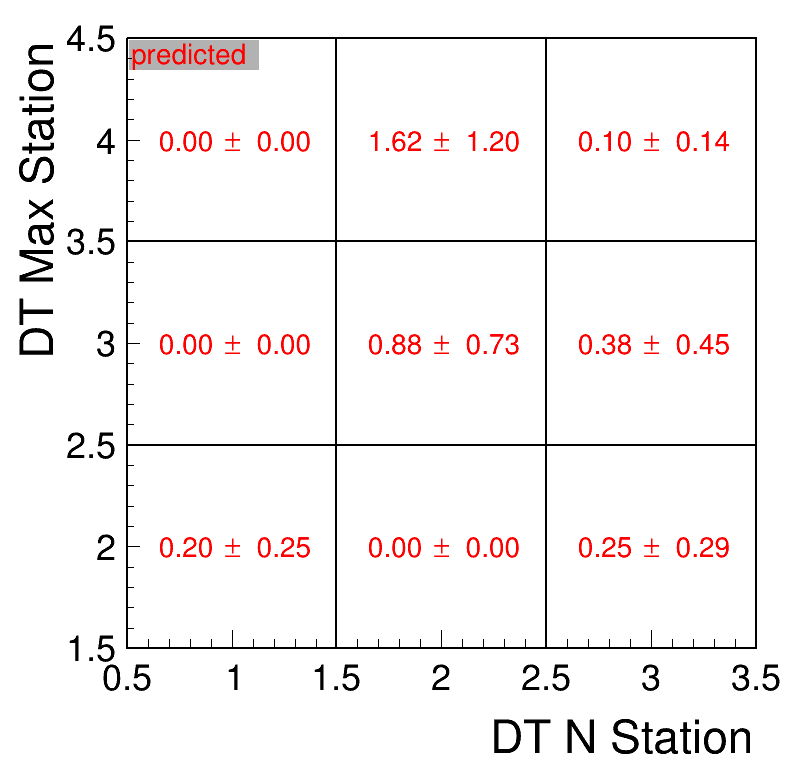

In [6]:
# ABCD By DT Station(s)
ims = 1
ms, name, weight, color = mss[ims], names[ims], weights[ims], colors[ims]
dphi, dtsize, dtnstn, dtmstn = ms["tag_dPhi"], ms["dtSize"], ms["dtNStation10"], ms["dtMaxStation"]
dtsize, dtnstn, dtmstn = np.ravel(dtsize), np.ravel(dtnstn), np.ravel(dtmstn)

blind_a = "dt oot" not in name.lower() and "signal" not in name.lower()
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, False
axis_titles = ["DT N Station", "DT Max Station", "Events in SR"]

# ABCD Conds
a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)

# ABCD by N and Max Station
# Empty canvas/hist
hh = rt.TH2D(f"h{np.random.randint(99999)}",";".join([""]+axis_titles), *bins)
canvas = rt.TCanvas(f"c{np.random.randint(99999)}", "", 800, 800)
canvas.SetRightMargin(0.05)
# canvas.SetGrid()
lat = rt.TLatex()
lat.SetTextSize(0.04)
lats, lines = [], []
abcd_n, abcd_m = [], []

# ABCD
print(name)
for nstn in range(1, 3 + 1):
    nstn_cond = dtnstn == nstn
    lines.append(rt.TLine(nstn-0.5, 2-0.5, nstn-0.5, 4+0.5))

    vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond)
    abcd_n.append((nstn, vals, errs))

    for mstn in range(2, 4 + 1):
        mstn_cond = dtmstn == mstn

        if nstn == 1:
            lines.append(rt.TLine(1-0.5, mstn-0.5, 3+0.5, mstn-0.5))

            vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, mstn_cond)
            abcd_m.append((mstn, vals, errs))

        vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond & mstn_cond)
        pa, a, pae, ae = vals[0], vals[1], errs[0], errs[1]

        if blind_a:
            lats.append((22, rt.kRed, (nstn, mstn, f"{pa:5.2f} #pm {pae:5.2f}")))
        else:
            lats.append((21, rt.kBlack, (nstn, mstn+0.1/2, f"{a:5.2f} #pm {ae:5.2f}")))
            lats.append((23, rt.kRed, (nstn, mstn-0.1/2, f"{pa:5.2f} #pm {pae:5.2f}")))
        # hh.Fill(nstn, mstn, pa)

lines.append(rt.TLine(nstn+0.5, 2-0.5, nstn+0.5, 4+0.5))
lines.append(rt.TLine(1-0.5, mstn+0.5, 3+0.5, mstn+0.5))

if not blind_a:
    lats.append((13, rt.kBlack, ((1-0.5)+0.02, (4+0.5)-0.02, "measured")))
lats.append((13, rt.kRed, ((1-0.5)+0.02, (4+0.5)-0.02-0.13*(not blind_a), "predicted")))

box = rt.TBox((1-0.5)+0.01,(4+0.5)-0.31/(2*blind_a),(1-0.5)+.63, (4+0.5)-0.01)
box.SetFillColorAlpha(rt.kBlack, 0.3)

hh.Draw("col same")
box.Draw()
for ll in lats:
    lat.SetTextAlign(ll[0])
    lat.SetTextColor(ll[1])
    lat.DrawLatex(*ll[2])
for line in lines:
    line.SetLineWidth(2)
    line.Draw()

canvas.Draw()


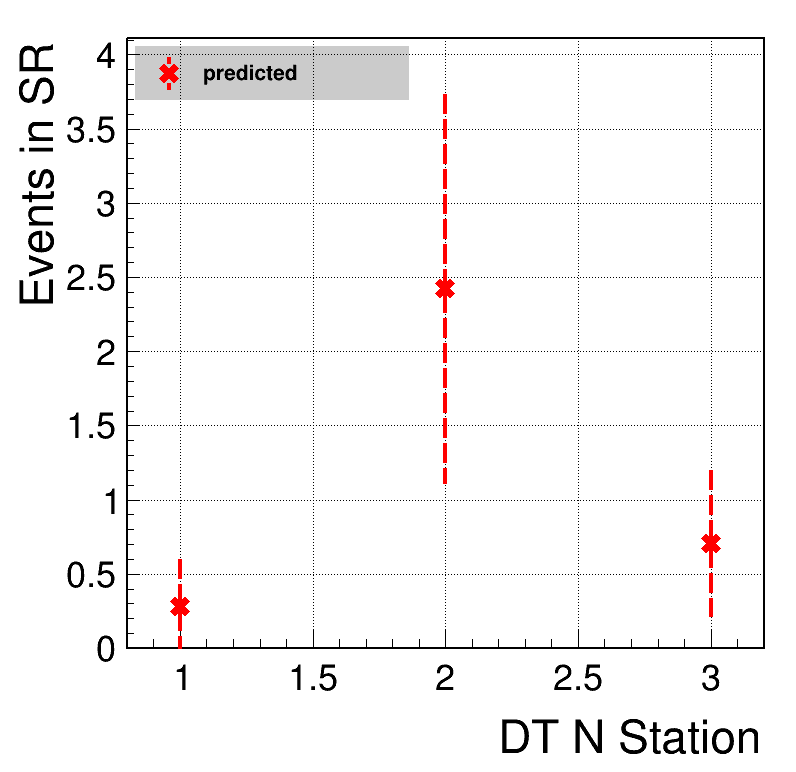

In [7]:
# ABCD By N Station
_stn, _a, _ae, _pa, _pae = [], [], [], [], []
for stn, vals, errs in abcd_n:
    _stn.append(stn)
    _a.append(vals[1])
    _pa.append(vals[0])
    _ae.append(errs[1])
    _pae.append(errs[0])

_stn = np.asarray(_stn)
_a, _ae = np.asarray(_a), np.asarray(_ae), 
_pa, _pae = np.asarray(_pa), np.asarray(_pae)

gr_m = create_TGraph(_stn, _a, [0.0] * len(_stn), _ae, [axis_titles[0], axis_titles[2]])
gr_p = create_TGraph(_stn, _pa, [0.0] * len(_stn), _pae, [axis_titles[0], axis_titles[2]])
canvas = rt.TCanvas("c" + str(np.random.randint(999999999)), "c", 800, 800)
canvas.SetGrid()
canvas.SetRightMargin(0.04)

legend = rt.TLegend(0.17, 0.91 - 0.04 * (1 if blind_a else 2), 0.21 + 0.016 * (8 + 11), 0.94)
legend.SetTextFont(62)
legend.SetTextSize(0.03)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(1, 0.2)
legend.SetEntrySeparation(0.01)

_min, _max = 0, max(max(_a+_ae), max(_pa+_pae))*(1+0.1)
for igr, gr in enumerate([gr_m, gr_p]):
    if blind_a and igr == 0:
        continue
    gr.SetMinimum(_min)
    gr.SetMaximum(_max)

    gr.SetLineColor(rt.kRed if igr else rt.kBlack)
    gr.SetFillColorAlpha(rt.kRed if igr else rt.kBlack, 0.3)
    gr.SetLineWidth(4)
    gr.SetLineStyle(9 if igr else 1)  # '--' if meas else '-'

    gr.SetMarkerColor(rt.kRed if igr else rt.kBlack)
    gr.SetMarkerSize(2.5 if igr else 2)
    gr.SetMarkerStyle(47 if igr else 20)  # x if meas else o

    legend.AddEntry(gr, "predicted" if igr else "measured", "PE")

    gr.Draw(("A" if igr==0 or blind_a else "") + "PE same")

legend.Draw()
canvas.Draw()


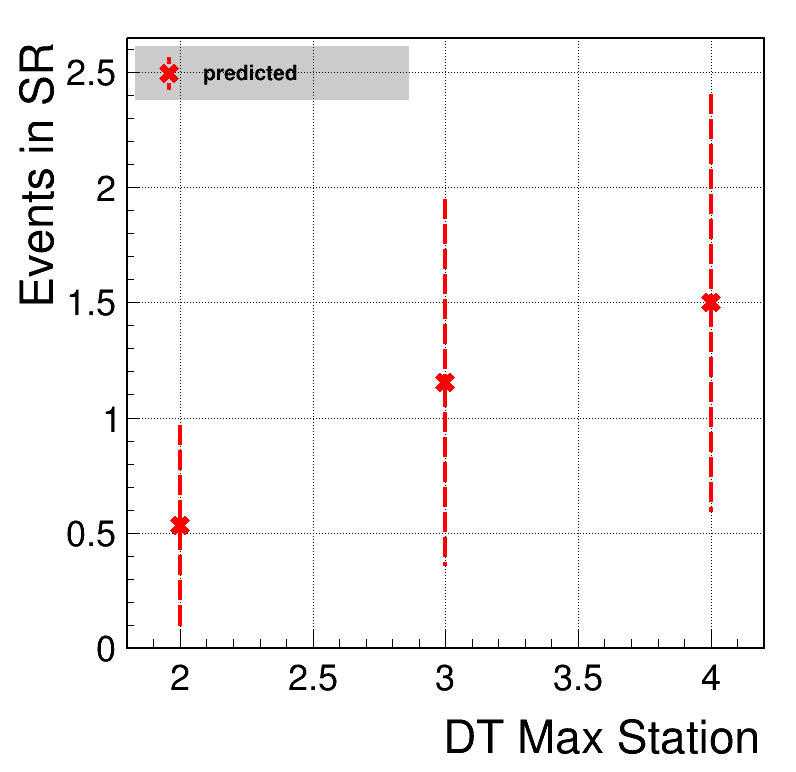

In [8]:
# ABCD By N Station
_stn, _a, _ae, _pa, _pae = [], [], [], [], []
for stn, vals, errs in abcd_m:
    _stn.append(stn)
    _a.append(vals[1])
    _pa.append(vals[0])
    _ae.append(errs[1])
    _pae.append(errs[0])

_stn = np.asarray(_stn)
_a, _ae = np.asarray(_a), np.asarray(_ae), 
_pa, _pae = np.asarray(_pa), np.asarray(_pae)

gr_m = create_TGraph(_stn, _a, [0.0] * len(_stn), _ae, [axis_titles[1], axis_titles[2]])
gr_p = create_TGraph(_stn, _pa, [0.0] * len(_stn), _pae, [axis_titles[1], axis_titles[2]])
canvas = rt.TCanvas("c" + str(np.random.randint(999999999)), "c", 800, 800)
canvas.SetGrid()
canvas.SetRightMargin(0.04)

legend = rt.TLegend(0.17, 0.91 - 0.04 * (1 if blind_a else 2), 0.21 + 0.016 * (8 + 11), 0.94)
legend.SetTextFont(62)
legend.SetTextSize(0.03)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(1, 0.2)
legend.SetEntrySeparation(0.01)

_min, _max = 0, max(max(_a+_ae), max(_pa+_pae))*(1+0.1)
for igr, gr in enumerate([gr_m, gr_p]):
    if blind_a and igr == 0:
        continue
    gr.SetMinimum(_min)
    gr.SetMaximum(_max)

    gr.SetLineColor(rt.kRed if igr else rt.kBlack)
    gr.SetFillColorAlpha(rt.kRed if igr else rt.kBlack, 0.3)
    gr.SetLineWidth(4)
    gr.SetLineStyle(9 if igr else 1)  # '--' if meas else '-'

    gr.SetMarkerColor(rt.kRed if igr else rt.kBlack)
    gr.SetMarkerSize(2.5 if igr else 2)
    gr.SetMarkerStyle(47 if igr else 20)  # x if meas else o

    legend.AddEntry(gr, "predicted" if igr else "measured", "PE")

    gr.Draw(("A" if igr==0 or blind_a else "") + "PE same")

legend.Draw()
canvas.Draw()


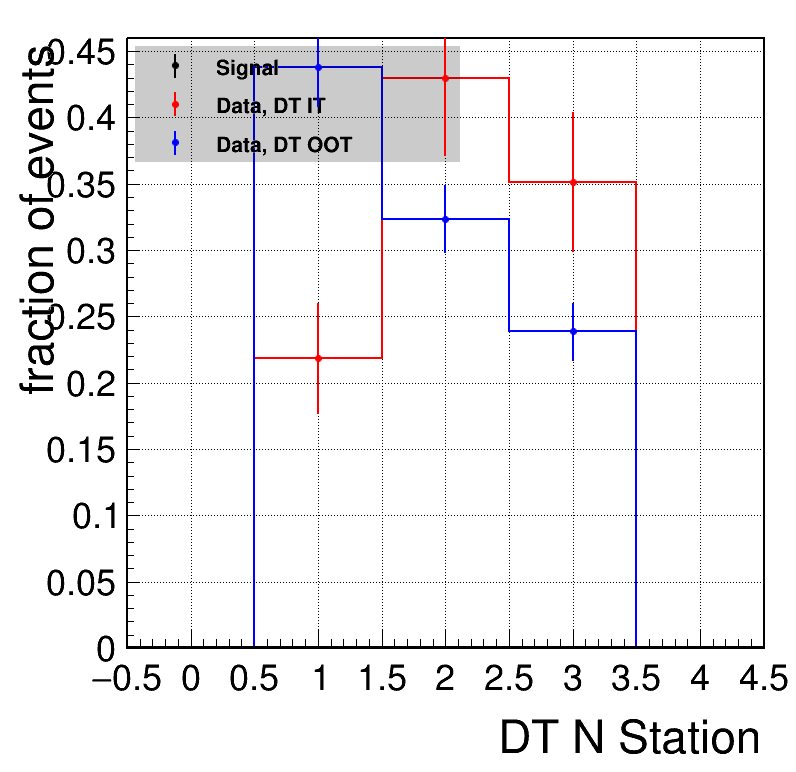

In [9]:
bins, log, norm = [5, -0.5, 4.5], False, True
axis_titles = ["DT N Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["dtNStation10"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

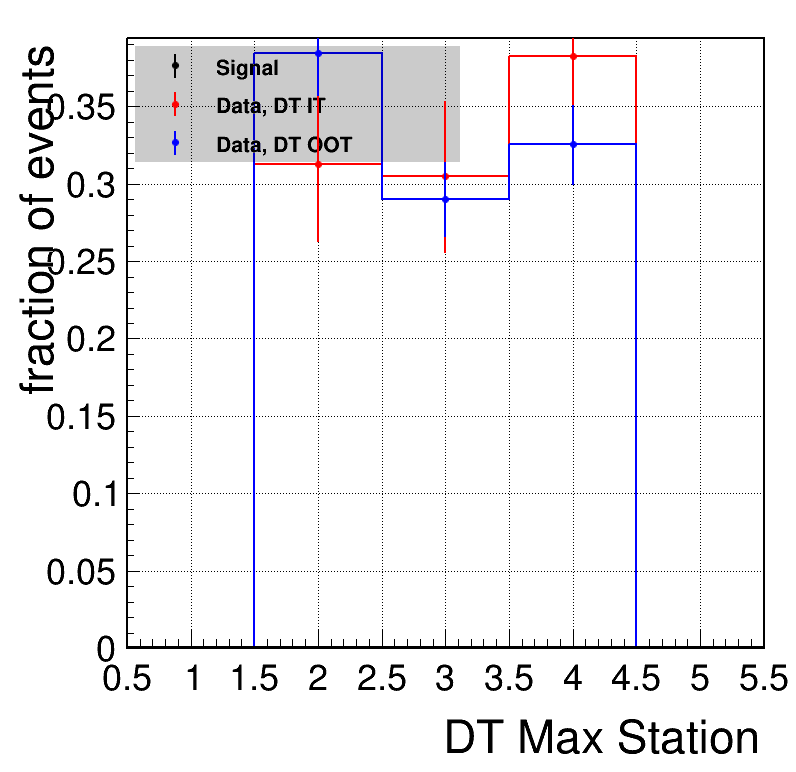

In [10]:
bins, log, norm = [5, 0.5, 5.5], False, True
axis_titles = ["DT Max Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["dtMaxStation"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

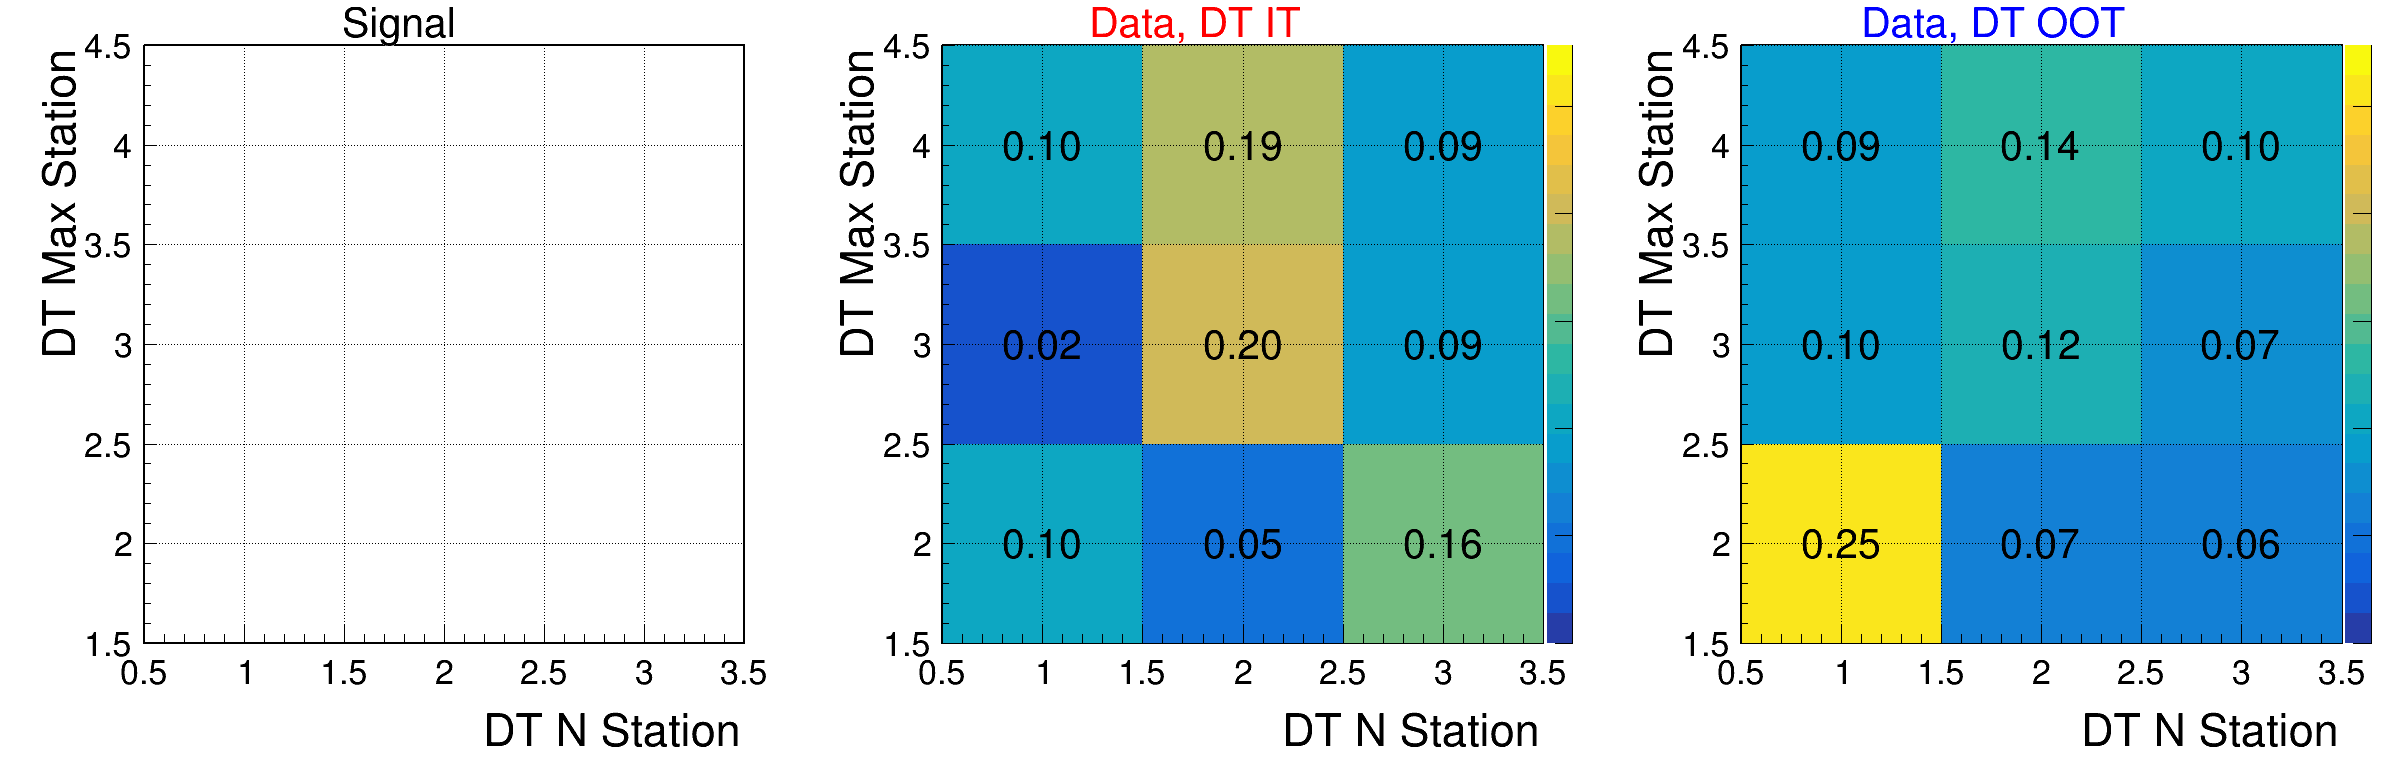

In [11]:
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, True
axis_titles = ["DT N Station", "DT Max Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["dtNStation10"], ms["dtMaxStation"]] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

rt.gStyle.SetPaintTextFormat("3.2f");
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

canvas.Draw()

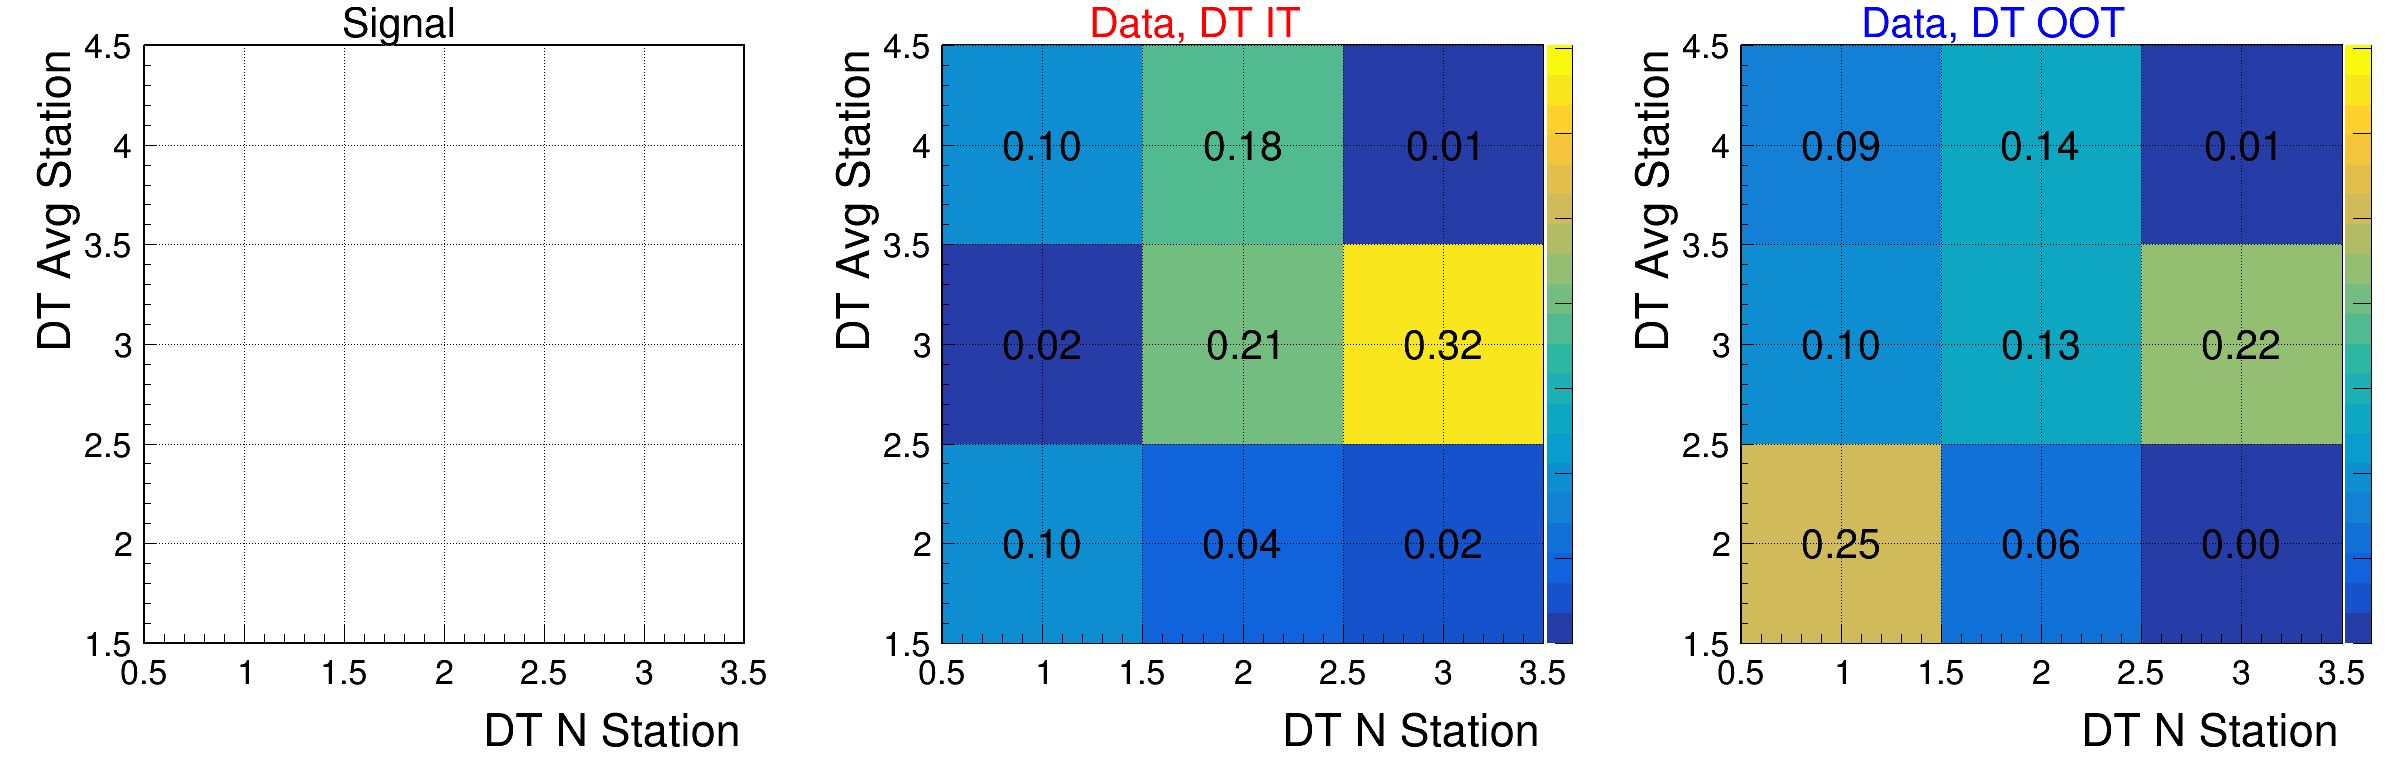

In [12]:
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, True
axis_titles = ["DT N Station", "DT Avg Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["dtNStation10"], ms["dtAvgStation10"]] for ms in mss]
"""
X: N, Y: M
Sig: 0.18+0.22+0.16+0.18+0.21 = 0.95
Bkg: 0.12+0.02+0.11+0.17+0.06 = 0.48

X: N, Y: A
Sig: 1-(0.02+0.02+0.00+0.01) = 0.95
Bkg: 1-(0.18+0.29+0.01+0.03) = 0.49
"""
_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

rt.gStyle.SetPaintTextFormat("3.2f");
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

canvas.Draw()

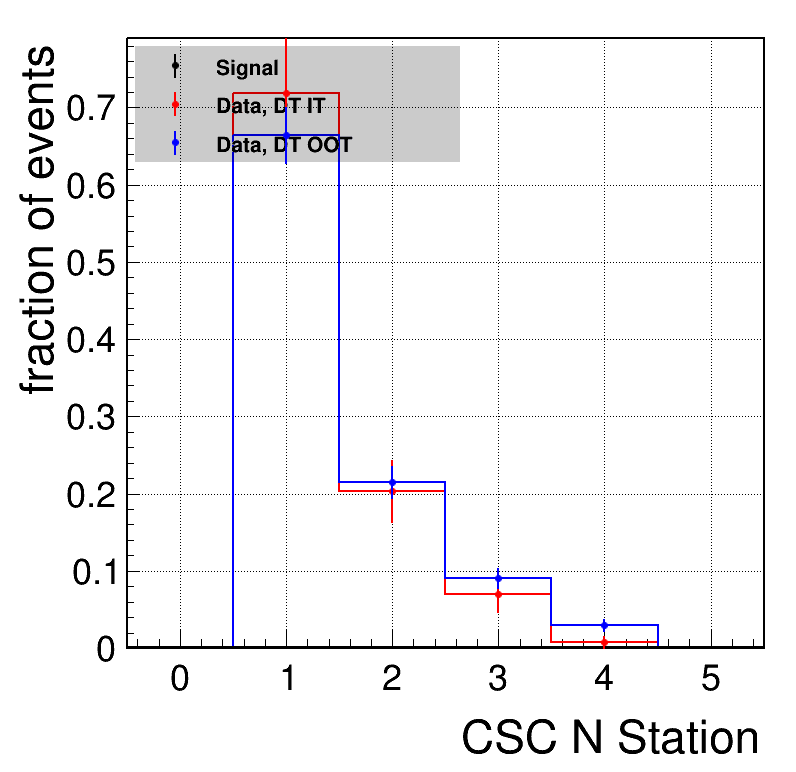

In [13]:
bins, log, norm = [6, -0.5, 5.5], False, True
axis_titles = ["CSC N Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscNStation10"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

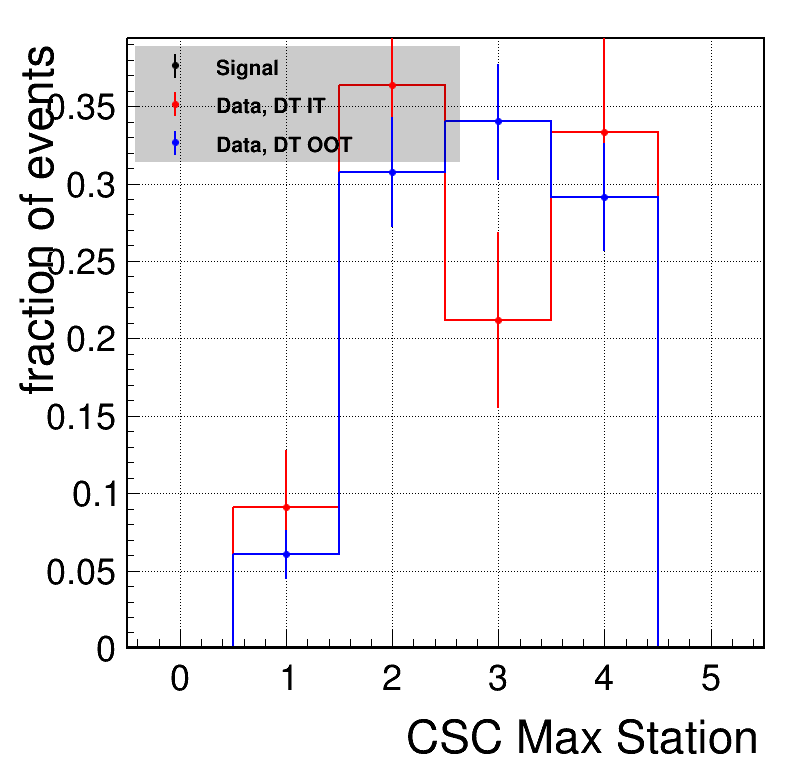

In [14]:
bins, log, norm = [6, -0.5, 5.5], False, True
axis_titles = ["CSC Max Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscMaxStation"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

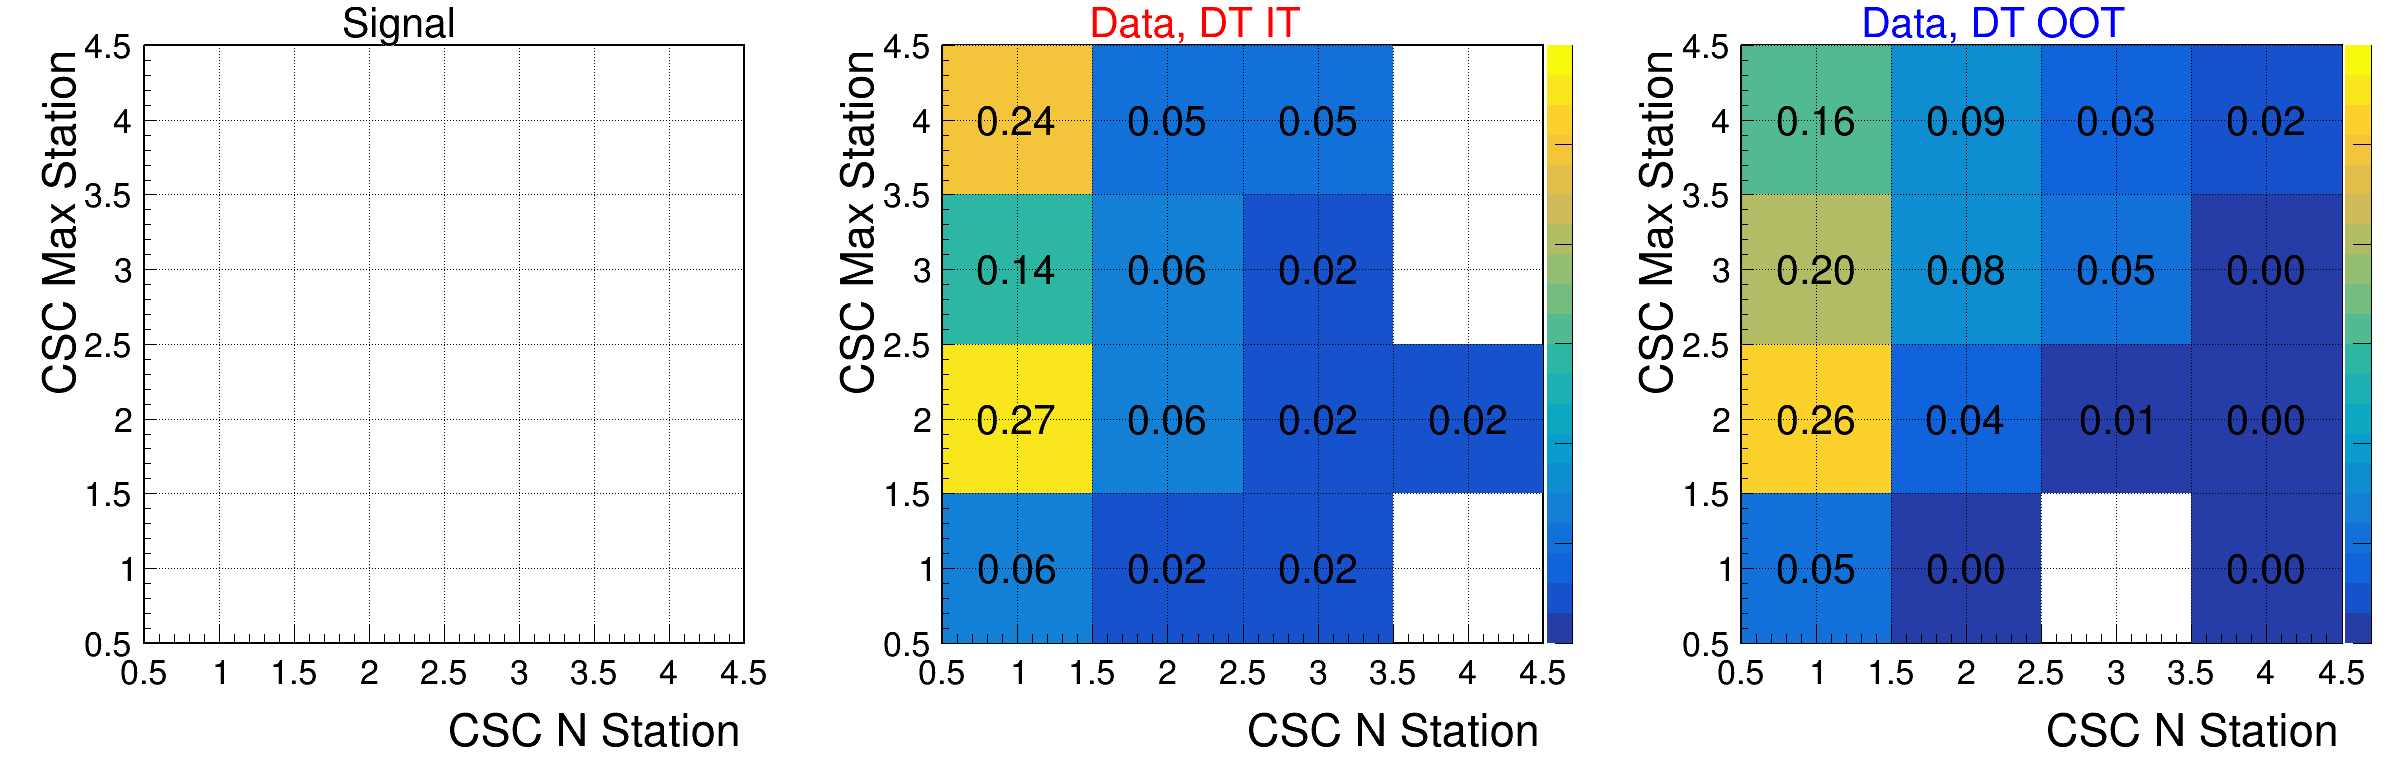

: 

In [15]:
bins, log, norm = [4, 0.5, 4.5, 4, 0.5, 4.5], False, True
axis_titles = ["CSC N Station", "CSC Max Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["cscNStation10"], ms["cscMaxStation"]] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

rt.gStyle.SetPaintTextFormat("3.2f");
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

canvas.Draw()